In [ ]:
import os
import numpy as np
import random

# 경로 설정
normal_dir = r"C:/Users/seohyun/OneDrive - dgu.ac.kr/동국대학교/4학년 1학기/종설/정상 전처리후/정상 전처리후"
abnormal_dir = r"C:/Users/seohyun/OneDrive - dgu.ac.kr/동국대학교/4학년 1학기/종설/비정상 전처리 후 20000개/비정상 전처리 후 20000개"


# 파일 목록 수집
normal_files = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith(".npy")]
abnormal_files = [os.path.join(abnormal_dir, f) for f in os.listdir(abnormal_dir) if f.endswith(".npy")]

# 셔플 후 일부만 사용
random.seed(42)  # 재현 가능성 확보
random.shuffle(normal_files)
random.shuffle(abnormal_files)

normal_sample = normal_files[:10000]
abnormal_sample = abnormal_files[:10000]

# 데이터 로딩
spectrograms, labels = [], []

# 정상은 0으로, 비정상은 1로 데이터 라벨링
for file in normal_sample:
    spectrograms.append(np.load(file))
    labels.append(0)

for file in abnormal_sample:
    spectrograms.append(np.load(file))
    labels.append(1)

# numpy array 변환 (파이토치 모델에서 사용할 수 있도록)
spectrograms = np.array(spectrograms)
labels = np.array(labels)

print(f"총 {len(spectrograms)}개의 샘플이 로드되었습니다.")

총 20000개의 샘플이 로드되었습니다.


In [ ]:
from torch.utils.data import Dataset
import torch

class SpectrogramDataset(Dataset):
    
    # 외부에서 스펙트로그램 배열과 정답(label)을 받아서 클래스 내부에 저장
    def __init__(self, spectrograms, labels):
        """
        spectrograms: numpy 배열 또는 torch tensor [N, H, W] ([채널, 높이, 너비])
        labels: numpy 배열 또는 list [N]
        """
        self.spectrograms = spectrograms
        self.labels = labels

    # 전체 샘플 개수 반환
    def __len__(self):
        return len(self.spectrograms)

    # 인덱스로 특정 샘플을 가져오기
    def __getitem__(self, idx):
        x = self.spectrograms[idx]
        y = self.labels[idx]

        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)

        y = torch.tensor(float(y), dtype=torch.float32)

        # 채널 추가 (2차원에서 3차원으로 차원을 추가해줘야 함)
        if x.ndim == 2:
            x = x.unsqueeze(0)

        # 모델 학습용 입력(x)과 정답(y)을 튜플로 반환
        return x, y

In [ ]:
# Dataset 생성
# 파이토치가 데이터를 (x, y) 형태로 하나씩 꺼낼 수 있음 ()
dataset = SpectrogramDataset(spectrograms, labels) # <- 사용자가 직접 만든 클래스

# DataLoader
# Dataset을 가지고 모델 학습에 필요한 배치(batch) 단위로 자동으로 묶어줌
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# 학습
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    
    # model: 학습할 CNN 모델
    # dataloader: 학습 데이터 (DataLoader) — 32개씩 배치로 들어옴
    # optimizer: 모델 가중치를 업데이트해주는 역할 (Adam 등)
    # loss_fn: 손실 함수 (BCELoss) — 예측과 정답의 차이를 계산
    # device: 학습할 장치 (cuda 또는 cpu)
    
    model.train() # 모델을 학습 모드로 설정
    
    # 손실과 정확도 초기화
    total_loss = 0 
    correct = 0
    total = 0

    # 데이터를 device로 이동하고 y shape 맞추기
    for x, y in dataloader:
        x = x.to(device)
        y = y.to(device).unsqueeze(1)

        # 예측 & 손실 계산 & 역전파
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        # 손실과 정확도 계산
        total_loss += loss.item()
        predicted = (pred > 0.7).float()
        correct += (predicted == y).sum().item()
        total += y.size(0)

    acc = correct / total * 100
    return total_loss / len(dataloader), acc

In [5]:
# 평가
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            pred = model(x)
            loss = loss_fn(pred, y)

            total_loss += loss.item()
            predicted = (pred > 0.7).float()
            correct += (predicted == y).sum().item()
            total += y.size(0)

    acc = correct / total * 100
    return total_loss / len(dataloader), acc


In [6]:
# train/test 나누기
from sklearn.model_selection import train_test_split

# 데이터셋 분할 (8:2 비율)
X_train, X_val, y_train, y_val = train_test_split(
    spectrograms, labels, test_size=0.2, stratify=labels, random_state=42
)

# 각각 Dataset 객체 생성
train_dataset = SpectrogramDataset(X_train, y_train)
val_dataset = SpectrogramDataset(X_val, y_val)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
# EmergencyCNN 정의
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmergencyCNN(nn.Module):
    def __init__(self, input_size=(128, 128)):
        super(EmergencyCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        # dummy input으로 FC 입력 크기 자동 계산
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, *input_size)
            x = self._forward_features(dummy_input)
            self.flat_dim = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flat_dim, 128)
        self.fc2 = nn.Linear(128, 1)  # binary classification

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

# 모델, 손실함수, 옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmergencyCNN(input_size=(64, 64)).to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [8]:
# 학습 루프
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)

    print(f"[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% || "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

[Epoch 1] Train Loss: 0.2623 | Train Acc: 87.20% || Val Loss: 0.1959 | Val Acc: 90.30%
[Epoch 2] Train Loss: 0.1956 | Train Acc: 91.82% || Val Loss: 0.1944 | Val Acc: 89.15%
[Epoch 3] Train Loss: 0.1735 | Train Acc: 92.36% || Val Loss: 0.1480 | Val Acc: 93.50%
[Epoch 4] Train Loss: 0.1586 | Train Acc: 92.98% || Val Loss: 0.1364 | Val Acc: 94.33%
[Epoch 5] Train Loss: 0.1448 | Train Acc: 94.04% || Val Loss: 0.1554 | Val Acc: 95.53%
[Epoch 6] Train Loss: 0.1323 | Train Acc: 94.61% || Val Loss: 0.1156 | Val Acc: 95.60%
[Epoch 7] Train Loss: 0.1236 | Train Acc: 95.01% || Val Loss: 0.1112 | Val Acc: 95.90%
[Epoch 8] Train Loss: 0.1174 | Train Acc: 95.45% || Val Loss: 0.1058 | Val Acc: 95.70%
[Epoch 9] Train Loss: 0.1117 | Train Acc: 95.63% || Val Loss: 0.1214 | Val Acc: 94.23%
[Epoch 10] Train Loss: 0.1086 | Train Acc: 95.68% || Val Loss: 0.0990 | Val Acc: 95.73%


In [9]:
# 한글깨짐 해결
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# Windows에서는 Malgun Gothic(맑은 고딕) 폰트 사용
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'AppleGothic'  # macOS일 경우
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

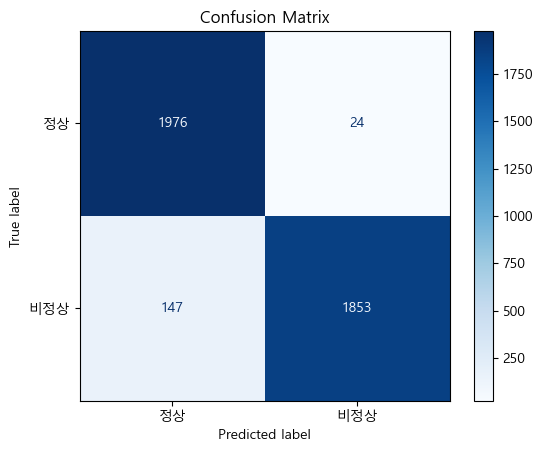

In [10]:
# 혼동 행렬 시각화
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            pred_label = (pred > 0.7).float().squeeze()

            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred_label.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["정상", "비정상"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# 실행
plot_confusion_matrix(model, val_loader, device)


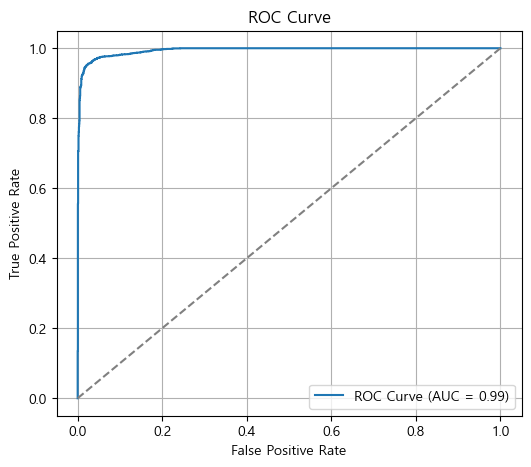

In [11]:
# ROC 커브 시각화
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, dataloader, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            y_true.extend(y.cpu().numpy())
            y_scores.extend(pred.cpu().numpy())

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# 실행
plot_roc_curve(model, val_loader, device)


In [12]:
# # 오탐지 샘플 추출
# def get_misclassified_samples(model, dataloader, device):
#     model.eval()
#     misclassified = []

#     with torch.no_grad():
#         for x, y in dataloader:
#             x = x.to(device)
#             y = y.to(device).unsqueeze(1)

#             preds = model(x)
#             pred_labels = (preds > 0.7).float()

#             for i in range(len(y)):
#                 true = y[i].item()
#                 pred = pred_labels[i].item()
#                 prob = preds[i].item()

#                 if true != pred:
#                     misclassified.append({
#                         'input': x[i].cpu(),  # 1xHxW
#                         'true': true,
#                         'pred': pred,
#                         'prob': prob
#                     })

#     return misclassified

# # 오탐지 샘플 리스트 가져오기 (validation 기준)
# misclassified_samples = get_misclassified_samples(model, val_loader, device)
# print(f"오탐지 샘플 수: {len(misclassified_samples)}개")
# misclassified_samples

def get_misclassified_samples(model, dataloader, device):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            preds = model(x)
            pred_labels = (preds > 0.7).float()

            for i in range(len(y)):
                true_label = y[i].item()
                pred_label = pred_labels[i].item()
                prob = preds[i].item()

                if true_label != pred_label:
                    misclassified.append({
                        'input': x[i].cpu(),  # (1, H, W)
                        'true': true_label,
                        'pred': pred_label,
                        'prob': prob
                    })

    return misclassified

# 오탐지 샘플 뽑기
misclassified_samples = get_misclassified_samples(model, val_loader, device)
print(f"오탐지 샘플 개수: {len(misclassified_samples)}개")


오탐지 샘플 개수: 171개


c:\Users\seohyun\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


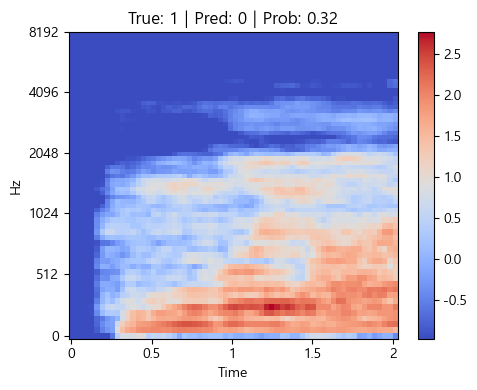

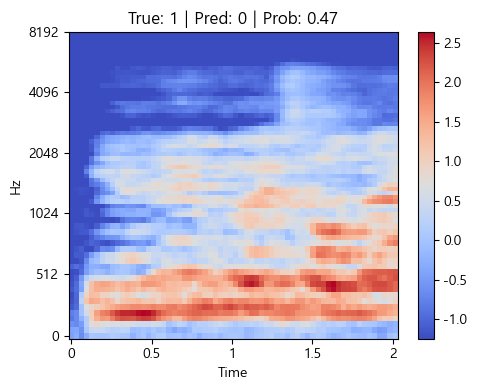

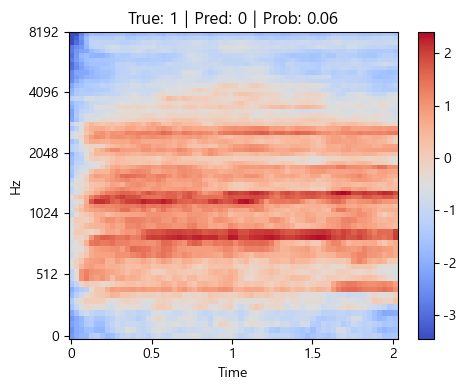

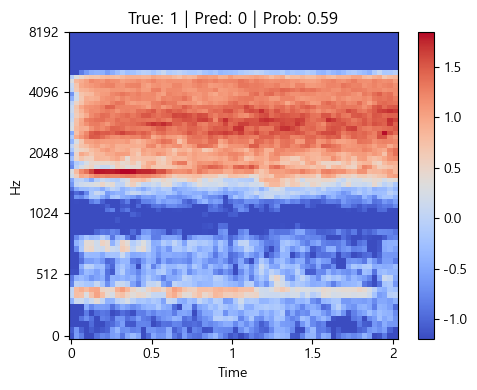

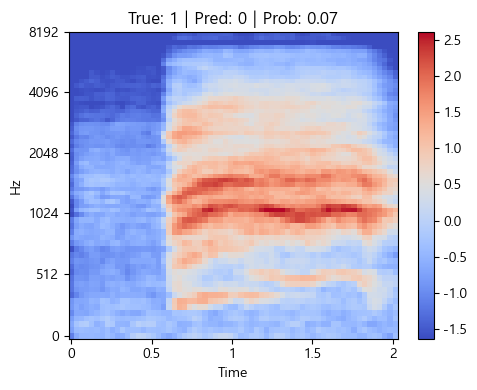

In [14]:
import librosa.display

def visualize_misclassified(misclassified, n=5):
    for i in range(min(n, len(misclassified))):
        sample = misclassified[i]
        plt.figure(figsize=(5, 4))

        # 🔽 Tensor → numpy 변환 추가
        spec = sample['input'].squeeze().cpu().numpy()

        librosa.display.specshow(spec, sr=16000, x_axis='time', y_axis='mel')
        plt.title(f"True: {int(sample['true'])} | Pred: {int(sample['pred'])} | Prob: {sample['prob']:.2f}")
        plt.colorbar()
        plt.tight_layout()
        plt.show()

# 오탐지 시각화 (5개 예시)
visualize_misclassified(misclassified_samples, n=5)

In [ ]:
# Threshold 튜닝 - 최적 임계값 찾기
from sklearn.metrics import f1_score
best_th = 0.5
best_f1 = 0

for th in np.linspace(0.1, 0.9, 9):
    y_true, y_prob = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            pred = model(x)
            y_true.extend(y.cpu().numpy())
            y_prob.extend(pred.cpu().numpy())

    preds = (np.array(y_prob) > th).astype(int)
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

print(f"Best F1: {best_f1:.4f} at threshold = {best_th}")


Best F1: 0.9625 at threshold = 0.7000000000000001
